This is not working. I keep getting an error in my last cell:  
`ValueError: n_components must be < n_features; got 2 >= 0`

So it's basically not finding any features. 

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

In [89]:
lemmatizer = WordNetLemmatizer()

In [90]:
df = pd.read_csv('issue_comments_jupyter_copy.csv')

df['org'] = df['org'].astype('str')
df['repo'] = df['repo'].astype('str')
df['comments'] = df['comments'].astype('str')
df['user'] = df['user'].astype('str')

In [91]:
struct_comments = df.comments.to_sparse()


In [92]:
from sklearn.base import TransformerMixin
class DenseTransformer1(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    
    
    
from sklearn.base import TransformerMixin
class DenseTransformer2():

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self
    
    
    
from sklearn.base import TransformerMixin
class DenseTransformer3():

    def transform(self, X, y=None, **fit_params):
        return X.A

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [93]:
struct_comments.head()

0                                           Thanks !\n
1    Oops. i got it. I have to uninstall ipython3 a...
2                                         same issue\n
3    FWIW a workaround is to share from Google Driv...
4    At some point, I'll probably hack on a Rethink...
Name: comments, dtype: object
BlockIndex
Block locations: array([0], dtype=int32)
Block lengths: array([5], dtype=int32)

In [94]:
#with open ('all_comments.txt',"wb") as fd:
 #   comments = struct_comments.str.cat(sep=' ')
 #   fd.write (comments)

In [95]:
from sklearn.feature_extraction import text
#stopwords = text.ENGLISH_STOP_WORDS
#stopwords = text.ENGLISH_STOP_WORDS.union(['jupyter', 'notebook', 'https', 'github', 'com', 'html', 'http', 'org','ellisonbg','don', 'n\'t'])
#stopwords = text.ENGLISH_STOP_WORDS.union(['jupyter', 'notebook', 'https', 'github', 'com', 'html', 'http', 'org','ellisonbg','don', 'n\'t', 'issue', 'thanks', 'work', 'just', 'like', 'think'])
stopwords = text.ENGLISH_STOP_WORDS.union(['jupyter', 'notebook', 'https', 'github', 'com', 'html', 'http', 'org','ellisonbg','don', 'n\'t', 'issue', 'thanks', 'work', 'just', 'like', 'think', 'make', 'doe', 'does', 'wa', 'need', 'thing'])

In [96]:
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) #split string into words (tokens)
    tokens = [t for t in tokens if len(t)>2 and len(t)<15] #remove short and long words,
    tokens = [lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
    return tokens

In [97]:
my_tokenizer("Oops. i got it. I have to uninstall ipython3")

['oops', 'got', 'uninstall']

In [98]:
import traceback
word_index_map = {}
current_index = 0
all_comments = []
index_word_map = []
all_tokens = []

for comment in struct_comments:
    try:
        comment = comment.encode('ascii', 'ignore')
        all_comments.append(comment)
        tokens = my_tokenizer(comment)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        pass
        

In [99]:
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens: 
        i = word_index_map[t]
        x[i] = 1
    return x

In [100]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N))
print X
print N
print D
print len(index_word_map)
print all_tokens[1]


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
16308
20492
20492
['oops', 'got', 'uninstall', 'install', 'brand', 'new', 'virtual', 'env', 'guess', 'want', 'add', 'note', '...', 'great', '...']


In [101]:
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i +=1
print X

[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  1.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


Below: Dimensionality reduction using truncated SVD (aka LSA).
This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.
In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

In [102]:
svd = TruncatedSVD()
Z = svd.fit_transform(X)


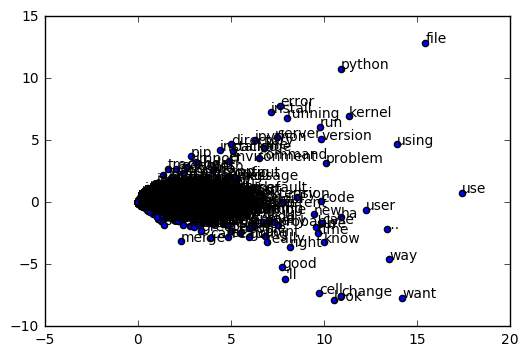

In [103]:
plt.scatter(Z[:,0], Z[:,1])
for i in xrange(D):
    plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
plt.show()